In [161]:
import sys
import os
from datetime import datetime

import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))
from Utils.data_utils import load_preprocessed_data_from_folder

In [162]:
# Load the data from the CSV file into a pandas DataFrame
data = load_preprocessed_data_from_folder()

data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.513755,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,0.610408,0.719411,0.497319,0.450999,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,0.584737,0.414652,0.562017,0.532866,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327,0.0
...,...,...,...,...,...,...,...,...,...,...
3991,0.482531,0.524160,0.308924,0.442628,0.504566,0.407946,0.539767,0.485483,0.599330,1.0
3992,0.371926,0.442095,0.411976,0.546609,0.596498,0.292375,0.416480,0.524698,0.460797,1.0
3993,0.471553,0.290820,0.524454,0.747456,0.432994,0.558864,0.430764,0.599290,0.580482,1.0
3994,0.483064,0.484272,0.490260,0.783886,0.364165,0.535721,0.349975,0.552053,0.439660,1.0


In [163]:
TEST_SIZE = 0.1
NUM_FOLDS = 5

train_df, test_df = train_test_split(data, test_size=TEST_SIZE)
train_df, test_df

(            ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
 3352  0.598507  0.662508  0.535596     0.556039  0.476209      0.296758   
 2066  0.481518  0.541913  0.381649     0.566934  0.529995      0.557234   
 2857  0.484951  0.389906  0.487902     0.426190  0.349592      0.227794   
 1730  0.441854  0.461980  0.359208     0.568023  0.590368      0.520422   
 2477  0.516252  0.576119  0.293897     0.460676  0.633920      0.639741   
 ...        ...       ...       ...          ...       ...           ...   
 3088  0.152038  0.526908  0.403642     0.579708  0.723005      0.510731   
 2134  0.402289  0.566932  0.312365     0.602411  0.387316      0.921106   
 3357  0.336843  0.566346  0.534840     0.505663  0.664310      0.606932   
 1964  0.543920  0.720365  0.542260     0.616089  0.615881      0.462147   
 809   0.416253  0.520773  0.419372     0.350046  0.531276      0.330280   
 
       Organic_carbon  Trihalomethanes  Turbidity  Potability  
 3352        0.570125 

In [164]:
train_y = train_df['Potability']
train_x = train_df.drop('Potability', axis=1)

test_y = test_df['Potability']
test_x = test_df.drop('Potability', axis=1)
train_x

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
3352,0.598507,0.662508,0.535596,0.556039,0.476209,0.296758,0.570125,0.549860,0.494297
2066,0.481518,0.541913,0.381649,0.566934,0.529995,0.557234,0.362570,0.251825,0.387780
2857,0.484951,0.389906,0.487902,0.426190,0.349592,0.227794,0.448454,0.623015,0.503608
1730,0.441854,0.461980,0.359208,0.568023,0.590368,0.520422,0.442310,0.411799,0.710101
2477,0.516252,0.576119,0.293897,0.460676,0.633920,0.639741,0.366278,0.499833,0.381842
...,...,...,...,...,...,...,...,...,...
3088,0.152038,0.526908,0.403642,0.579708,0.723005,0.510731,0.463084,0.451151,0.452280
2134,0.402289,0.566932,0.312365,0.602411,0.387316,0.921106,0.519243,0.555385,0.389863
3357,0.336843,0.566346,0.534840,0.505663,0.664310,0.606932,0.406303,0.372103,0.575012
1964,0.543920,0.720365,0.542260,0.616089,0.615881,0.462147,0.328111,0.792058,0.291318


In [165]:
params = {
    'objective': 'binary:logistic',  # binary classification problem
    'eval_metric': 'logloss',         # evaluation metric: logarithmic loss
    'eta': 0.1,                       # learning rate
    'max_depth': 6,                   # maximum depth of a tree
    'subsample': 0.8,                 # subsample ratio of the training instances
    'colsample_bytree': 0.8,          # subsample ratio of columns when constructing each tree
    'seed': 42                        # random seed for reproducibility
}

# Train the XGBoost model
num_round = 100

In [166]:
bst = xgb.train(params, xgb.DMatrix(train_df.drop('Potability', axis=1), label=train_y), num_round)

y_pred_proba = bst.predict(xgb.DMatrix(test_x))
y_pred = np.round(y_pred_proba)
f1 = f1_score(test_y, y_pred)

print(f"F1 Score: {f1:.2%}")

F1 Score: 74.75%


In [167]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [168]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    nthread=-1)

In [169]:
from sklearn.model_selection import StratifiedKFold

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

In [170]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [171]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='f1', n_jobs=4, cv=skf.split(train_df.drop('Potability', axis=1),train_y), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(train_df.drop('Potability', axis=1), train_y)
timer(start_time)

Fitting 3 folds for each of 5 candidates, totalling 15 fits

 Time taken: 0 hours 0 minutes and 1.8 seconds.


In [172]:
import pandas as pd

print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 All results:
{'mean_fit_time': array([0.16488902, 0.53506756, 0.44633579, 0.1395158 , 0.32372204]), 'std_fit_time': array([0.00436751, 0.02242759, 0.05860685, 0.01452717, 0.00504928]), 'mean_score_time': array([0.00696063, 0.00770322, 0.0062418 , 0.00672317, 0.00503842]), 'std_score_time': array([0.00153077, 0.00160906, 0.00161816, 0.00110998, 0.00425536]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 5, 5, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dt

In [173]:
random_search.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 5,
 'gamma': 1.5,
 'colsample_bytree': 0.8}

In [174]:
ideal_xgb = XGBClassifier(**random_search.best_params_)
ideal_xgb.fit(train_df.drop('Potability', axis=1), train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [176]:
y_test_pred = pd.Series(ideal_xgb.predict(test_df.drop('Potability', axis=1)))
f1_score_test = f1_score(test_y, y_test_pred)
print(f'{f1_score_test:.2%}')

70.03%


In [177]:
labels = ['Not Potable','Water Potable']
cm = confusion_matrix(test_y, y_pred,labels=[0, 1])

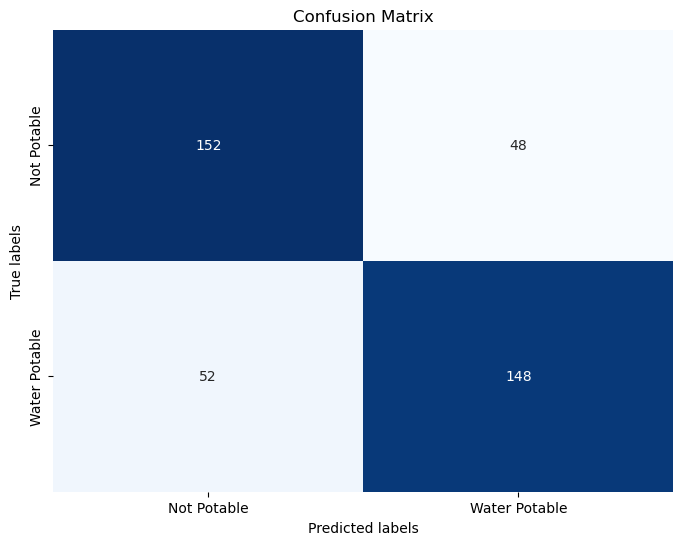

In [178]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [179]:
calibrated_xgb = CalibratedClassifierCV(ideal_xgb, cv=NUM_FOLDS)
calibrated_xgb.fit(train_df.drop('Potability', axis=1), train_y)
test_x = test_df.drop('Potability', axis=1)
print(f'Calibrated SVC test accuracy: {calibrated_xgb.score(test_x, test_y):0.2%}')

Calibrated SVC test accuracy: 75.75%


In [180]:
y_proba = calibrated_xgb.predict_proba(test_x)[:, 1]
y_proba

array([0.32798711, 0.58628831, 0.39962575, 0.68975152, 0.78351138,
       0.6379611 , 0.4911432 , 0.22484049, 0.6672588 , 0.69633913,
       0.20557726, 0.80659888, 0.2109033 , 0.38498941, 0.39898617,
       0.39805897, 0.69909534, 0.47181261, 0.31557014, 0.23365442,
       0.63074427, 0.59497982, 0.65844557, 0.62965215, 0.50822164,
       0.67552736, 0.4147699 , 0.24911534, 0.22321158, 0.67702734,
       0.76079749, 0.67492133, 0.49233121, 0.59755808, 0.53878132,
       0.64574639, 0.45317253, 0.80218476, 0.32034569, 0.31753165,
       0.55837649, 0.6041801 , 0.65217667, 0.43198506, 0.55251628,
       0.4910189 , 0.78549935, 0.46747871, 0.59626324, 0.3022139 ,
       0.57140648, 0.43239117, 0.56636701, 0.78780628, 0.56479319,
       0.19699382, 0.36528795, 0.59062749, 0.50943266, 0.52632949,
       0.41472632, 0.59710284, 0.68945471, 0.80186905, 0.38821159,
       0.47519642, 0.44299005, 0.62865053, 0.49338335, 0.46976286,
       0.37563987, 0.54016979, 0.67920923, 0.34784495, 0.34085

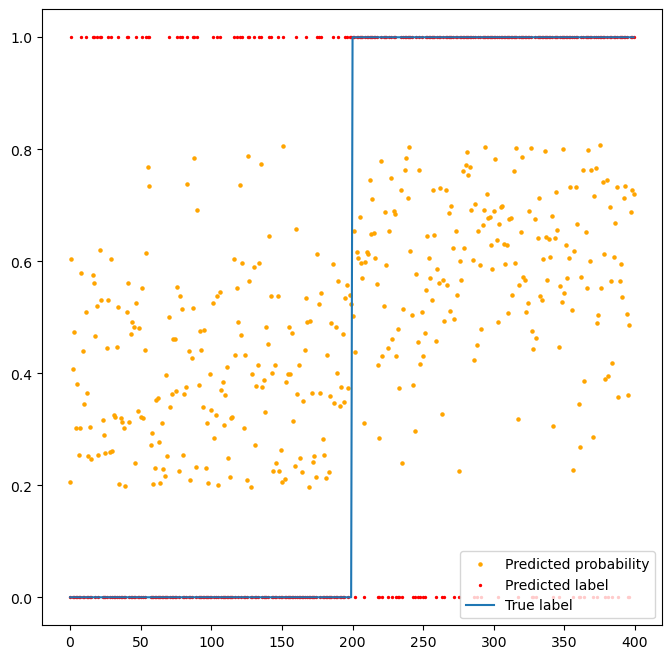

In [181]:
# Create a zipped array of sample index, predicted proability and true label
results = np.column_stack((calibrated_xgb.predict_proba(test_x)[:, 1], calibrated_xgb.predict(test_x), test_y))

# Sort by true label
results = results[results[:, 2].argsort()]

# Plot the predicted probabilities & true labels

plt.figure(figsize=(8, 8))
plt.scatter(range(len(results)), results[:, 0], label='Predicted probability', c='orange', s=5)
plt.scatter(range(len(results)), results[:, 1], label='Predicted label', c='red', s=2)
plt.plot(results[:, 2], label='True label')
plt.legend()

plt.show()

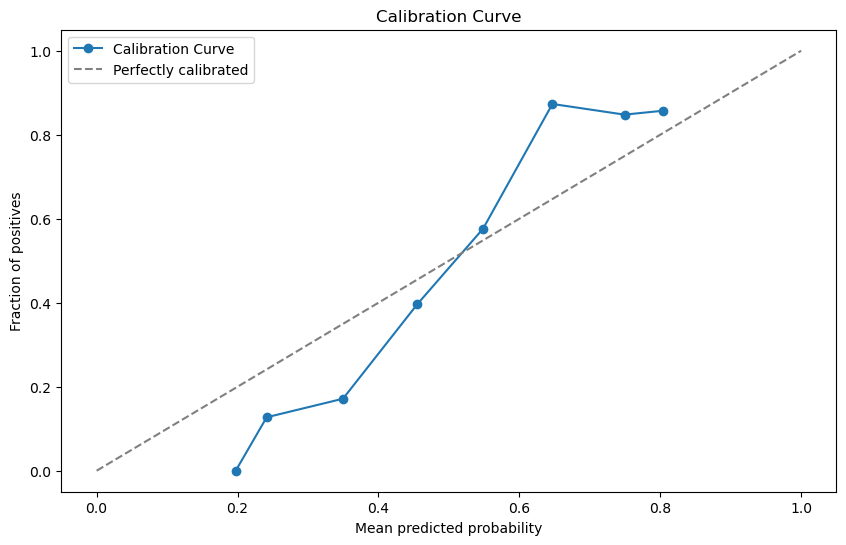

In [182]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(test_y, y_proba, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()